In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ast import literal_eval

In [3]:
base_operations = {
    "ADD_ENERGY": [
        "HeatChill",
        "HeatChillToTemp",
        "StartHeatChill",
        "Irradiate",
        "Stir",
        "StartStir",
    ],
    "REMOVE_ENERGY": [],
    "ADD_MATTER": ["Add", "AddSolid", "Transfer", "Dissolve"],
    "REMOVE_MATTER": [
        "Purge",
        "Separate",
        "EvacuateAndRefill",
        "Filter",
        "FilterThrough",
        "WashSolid",
        "Dry",
        "Evaporate",
        "PreparativeChromatography",
        "Recrystallize",
    ],
    "IGNORE": [
        "ResetHandling",
        "Repeat",
        "Wait",
        "CleanVessel",
        "Monitor",
        "StopStir",
        "StopPurge",
        "StopHeatChill",
        "CSwitchArgon",
        "Async",
        "SwitchVacuum",
        "Wait",
        "CConect",
    ],
}

In [4]:
double_step_procs = {
    1: ["0034", "0010"],
    2: ["0035", "0010"],
    3: ["0078", "0037"],
    4: ["0037", "0012"],
    5: ["0075", "0004"],
    6: ["0004", "0005"],
    7: ["0056", "0022"],
    8: ["0056", "0023",],
    9: ["0038", "0079"],
    10: ["0040", "0042"],
    11: ["0043", "0044"],
    12: ["0044", "0045"],
    13: ["0046", "0047"],
}

triple_step_procs = {
    1: ["0034", "0035", "0010"],
    2: ["0078", "0037", "0012"],
    3: ["0075", "0004", "0005"],
    4: ["0043", "0044", "0045"]
}

In [6]:
df_all = pd.read_csv("../data/xdl_steps_per_rxn_step.csv", index_col=0)
xdl_stats = pd.read_csv("../data/xdl_stats.csv", index_col=0).to_dict(orient="index")
xdl_stats_single = pd.read_csv("../data/xdl_stats_single.csv", index_col=0).to_dict(orient="index")

C:\Users\pagel\AppData\Local\Temp\ipykernel_103676\4264894679.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


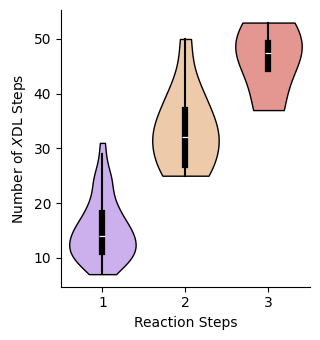

In [7]:
pastel_colors = ["#cba6f7", "#f8c99e", "#f28b82"]

# Plot
fig, ax = plt.subplots(figsize=(3.3, 3.5))

sns.violinplot(
    data=df_all,
    x="reaction_type",
    y="n_steps",
    ax=ax,
    palette=pastel_colors,
    cut=0,
    linewidth=1,
    inner="box",
    linecolor="black",
)

# Beautify
ax.set_xlabel("Reaction Steps")
ax.set_ylabel(r"Number of $X$DL Steps")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.grid(True, linestyle="--", axis='y', alpha=0.4)

plt.savefig("xdl_steps_violin.svg", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()


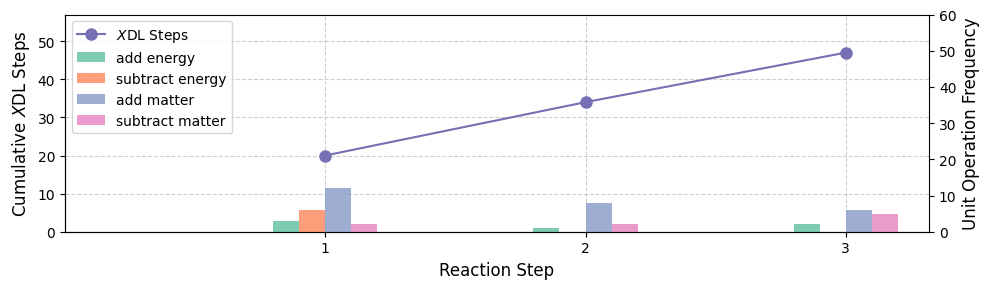

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))  # Only one subplot now
colors = plt.cm.Dark2(np.linspace(0, 1, len(xdl_stats)))
bar_width = 0.1

# Define base ops (excluding "IGNORE") and palette
ops = [op for op in base_operations if op != "IGNORE"]
palette = sns.color_palette("Set2", n_colors=len(ops))

for key, stats in xdl_stats.items():
    color = colors[2]
    if key == 3:
        # Line on primary axis: cumulative steps
        if isinstance(stats['n_steps'], str):
            stats['n_steps'] = literal_eval(stats['n_steps'])
        cumulative_steps = [sum(stats['n_steps'][:i+1]) for i in range(len(stats['n_steps']))]
        ax.plot(
            cumulative_steps,
            label=fr'$X$DL Steps',
            marker='o',
            color=color,
            markersize=8
        )
        ax.set_ylim(0, 57)

        # Secondary y-axis for bars
        ax2 = ax.twinx()

        # Plot grouped bars
        if isinstance(stats['base_operation_frequencies'], str):
            base_ops = literal_eval(stats['base_operation_frequencies'])
        else:
            base_ops = stats['base_operation_frequencies']
        n_steps = len(stats['n_steps'])
        x = np.arange(n_steps)

        for i, op in enumerate(ops):
            heights = [base_ops[j][op] for j in range(n_steps)]
            offset = (i - len(ops)/2) * bar_width + bar_width/2
            ax2.bar(
                x + offset,
                heights,
                width=bar_width,
                label=op.replace("_", " ").lower().replace("remove", "subtract"),
                alpha=0.85,
                color=palette[i]
            )

        # Axis formatting
        ax2.set_ylim(0, 60)
        ax.set_ylabel(r"Cumulative $X$DL Steps", fontsize=12)
        ax2.set_ylabel("Unit Operation Frequency", fontsize=12)

        # Combined legend
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax2.legend(h1 + h2, l1 + l2, loc='upper left')

        # X-axis
        ax.set_xlabel('Reaction Step', fontsize=12)
        ax.set_xticks(range(n_steps))
        ax.set_xticklabels([f'{i+1}' for i in range(n_steps)])

        break  # Only handle key == 3

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlim(left=-1)

plt.tight_layout()
plt.savefig("cumulative_step.svg", dpi=300)
plt.show()


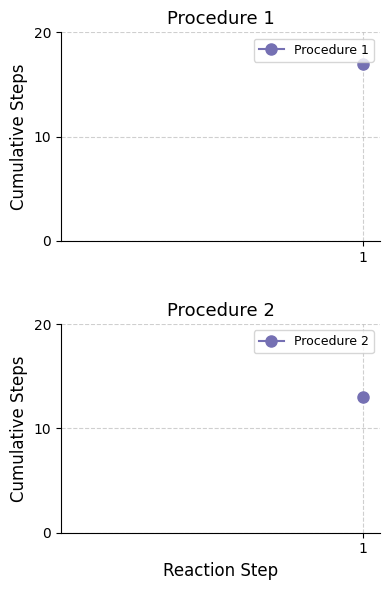

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(4,6), sharex=False)
colors = plt.cm.Dark2(np.linspace(0, 1, 9))

for i, idx in enumerate([1, 2]):
    stats = xdl_stats_single[idx]
    if isinstance(stats['n_steps'], str):
        stats['n_steps'] = literal_eval(stats['n_steps'])
    
    cumulative_steps = [sum(stats['n_steps'][:j+1]) for j in range(len(stats['n_steps']))]
    color = colors[2]

    ax[i].plot(cumulative_steps, label=f'Procedure {idx}', marker='o', color=color, markersize=8)
    ax[i].set_ylabel('Cumulative Steps', fontsize=12)
    ax[i].set_title(f'Procedure {idx}', fontsize=13)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].grid(True, linestyle='--', alpha=0.6)
    ax[i].legend(fontsize=9)
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].set_ylim(bottom=0)
    ax[i].set_xlim(left=-1)
    ax[i].set_xticks(range(len(stats['n_steps'])))
    ax[i].set_xticklabels([f'{j+1}' for j in range(len(stats['n_steps']))])
    ax[i].set_yticks(range(0, sum(stats['n_steps']) + 10, 10))

ax[-1].set_xlabel('Reaction Step', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.savefig("cumulative_steps_1_2.svg", dpi=300)
plt.show()
